In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "../Plant",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [4]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [5]:
classes = dataset.class_names
print(classes)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


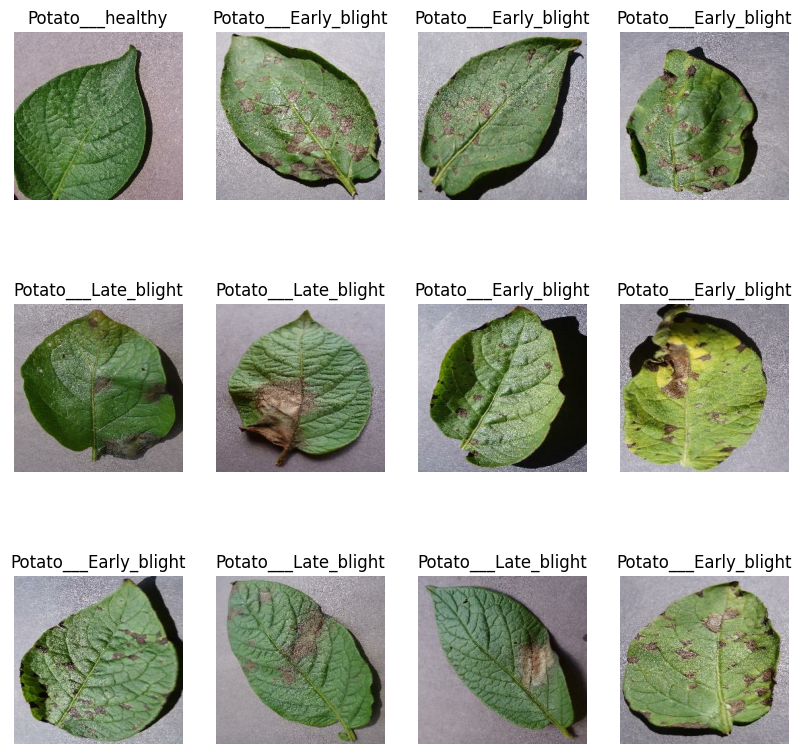

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.title(classes[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype(int))
        plt.axis("off")

first len(dataset)*0.8 = 54 batches will be taken for training

In [7]:
train_size = int(len(dataset)*0.8)
train_ds = dataset.take(train_size)

In [8]:
val_size = int(len(dataset)*0.1)
validation_ds = dataset.skip(train_size).take(val_size)
test_batch = len(dataset) - train_size - val_size 
test_ds = dataset.skip(train_size+val_size)

In [9]:
print(train_size, len(test_ds), val_size)

54 8 6


In [10]:
def split_dataset(ds, train_split=0.8, test_split=0.1, val_spilt=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    train_size = int(ds_size*0.8)
    val_size = int(ds_size*0.1)
    test_size = ds_size - train_size - val_size
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size+val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = split_dataset(dataset)

In [12]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(scale=1.0/255)
])

In [14]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3;
model = tf.keras.Sequential([
    resize_and_rescale,
    data_augment,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics='accuracy'
)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [18]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=32, 
    validation_data=val_ds,
)

Epoch 1/50
54/54 [==============================] - 68s 1s/step - loss: 0.9232 - accuracy: 0.4560 - val_loss: 0.8906 - val_accuracy: 0.4583
Epoch 2/50
54/54 [==============================] - 62s 1s/step - loss: 0.7231 - accuracy: 0.6426 - val_loss: 0.5445 - val_accuracy: 0.7679
Epoch 3/50
54/54 [==============================] - 60s 1s/step - loss: 0.4965 - accuracy: 0.8003 - val_loss: 0.3496 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 59s 1s/step - loss: 0.3815 - accuracy: 0.8474 - val_loss: 0.3579 - val_accuracy: 0.8646
Epoch 5/50
54/54 [==============================] - 59s 1s/step - loss: 0.3253 - accuracy: 0.8703 - val_loss: 0.2783 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 60s 1s/step - loss: 0.2430 - accuracy: 0.9049 - val_loss: 0.1721 - val_accuracy: 0.9010
Epoch 7/50
54/54 [==============================] - 59s 1s/step - loss: 0.2260 - accuracy: 0.9061 - val_loss: 0.1719 - val_accuracy: 0.9219
Epoch 8/50
54/54 [==

1/1 [==============================] - 0s 437ms/step


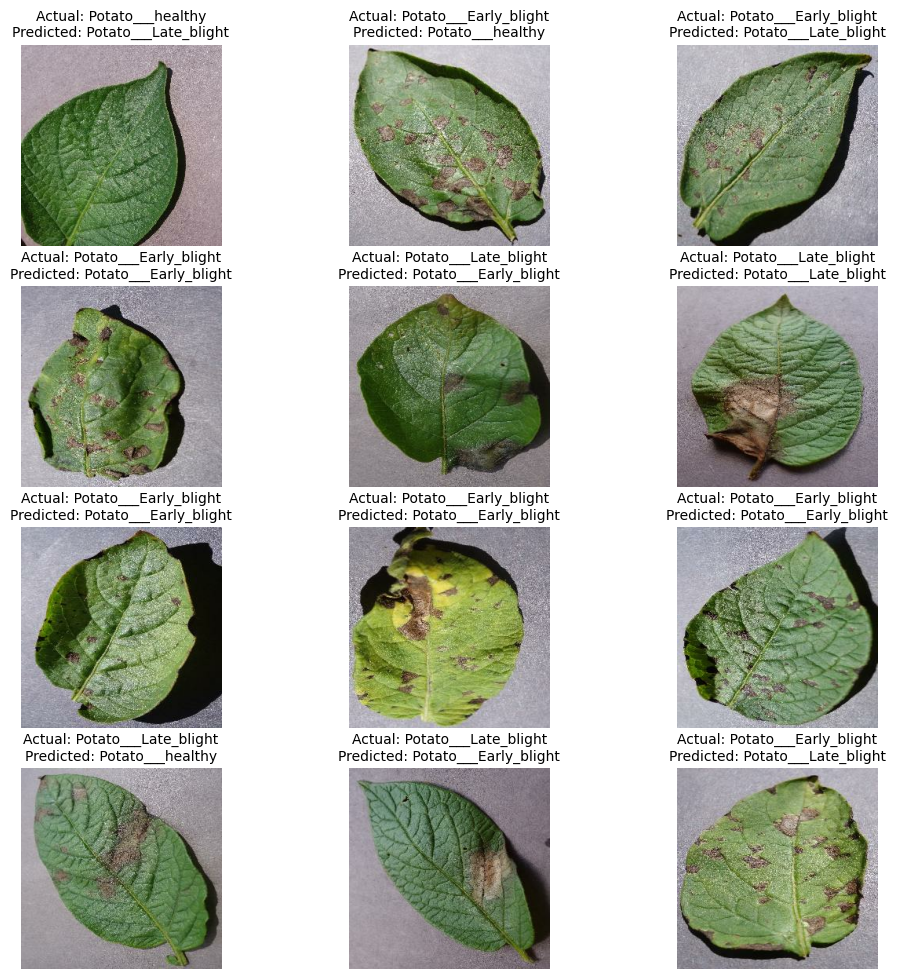

In [19]:
plt.figure(figsize=(12, 12))
for imageBatch, labelBatch in dataset.take(1):
    prediction = model.predict(imageBatch)
    for i in range(12):
        index = np.argmax(prediction[i])
        plt.subplot(4, 3, i+1)
        plt.title(f"Actual: {classes[label_batch[i]]}\nPredicted: {classes[index]}", fontsize=10)
        plt.imshow(image_batch[i].numpy().astype(int))
        plt.axis("off")

In [20]:
model.evaluate(train_ds)

54/54 [==============================] - 13s 225ms/step - loss: 0.1150 - accuracy: 0.9707


[0.11504650861024857, 0.9706572890281677]

Text(0.5, 1.0, 'Model Training History')

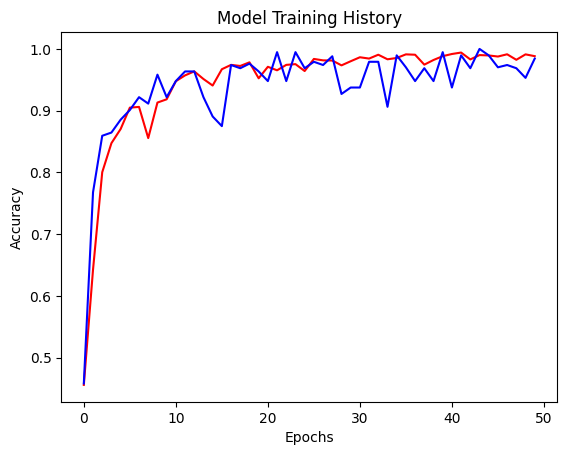

In [21]:
plt.plot(history.history['accuracy'], c='red')
plt.plot(history.history['val_accuracy'], c='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Training History")

Text(0.5, 1.0, 'Model Training History')

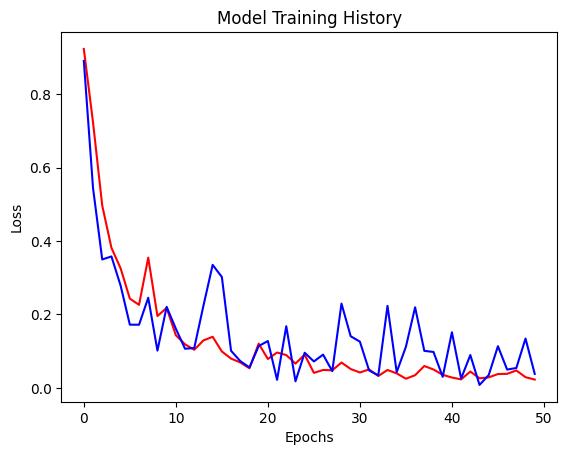

In [22]:
plt.plot(history.history['loss'], c='red')
plt.plot(history.history['val_loss'], c='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Training History")

In [23]:
model.evaluate(test_ds)

8/8 [==============================] - 3s 227ms/step - loss: 0.0756 - accuracy: 0.9766


[0.07559622079133987, 0.9765625]

In [24]:
def predict(model, img):
    image = tf.expand_dims(img, 0)
    prediction = model.predict(image)
    index = np.argmax(prediction[0])
    confidence = 100*prediction[0][index]
    return confidence, classes[index]

In [25]:
Image = 1;
for imagebatch, labelbatch in dataset.take(1):
    Image = imagebatch[0].numpy()

1/1 [==============================] - 0s 144ms/step


Text(0.5, 1.0, 'Prediction: Potato___Early_blight \nConfidence: 100.00')

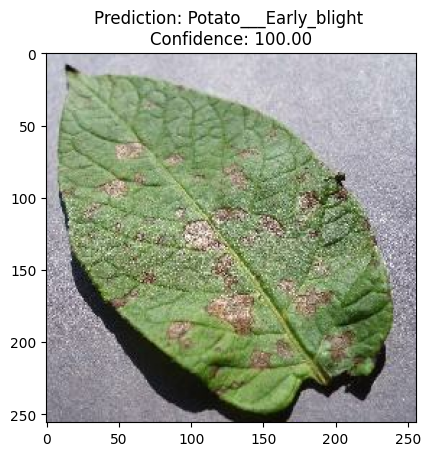

In [26]:
plt.imshow(Image.astype(int))
img_predict = predict(model, Image)
plt.title(f"Prediction: {img_predict[1]} \nConfidence: {img_predict[0] :.2f}")

In [29]:
import os
files = os.listdir("../models/")
model_version=len(files)+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
